# Simple tests

This notebook contains some simple code for testing the performance of scikit-learn classifiers.

In [1]:
from __future__ import division, print_function
import time
import pickle
import warnings
warnings.filterwarnings('default')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import ndimage

/home/virginia/.local/lib/python2.7/site-packages/scipy/spatial/__init__.py:96: ImportWarning: Not importing directory '/home/virginia/.local/lib/python2.7/site-packages/scipy/spatial/qhull': missing __init__.py
  from .qhull import *


### Evaluation metrics

In the cell below we define a bunch of functions that help evaluate a classifier by calculating confusion matrices and by implementing cross-validation.

In [2]:
def construct_confusion_matrix(actual, predicted, dim=10):
    '''
        This function constructs the confusion matrix for a given input
        of actual and predicted class vectors with integers as class labels.
        
        Parameters
        ----------------------
        actual : array, dtype int
            A 1D row vector of length N containing the actual class labels
        
        predicted : array, dtype int
            A 1D row vector of length N containing the predicted class labels
        
        dim : integer
            The (one-axis) size of the confusion matrix. This will depend on how
            many classes there are in the data.
            
        Returns
        ----------------------
        confusion_matrix : array
            The confusion matrix constructed from actual and predicted class
            labels with dimension (N, N).
    '''
    confusion_matrix = np.zeros((dim, dim))
    for row, col in zip(actual, predicted):
        confusion_matrix[row, col] += 1
    return confusion_matrix

def plot_confusion_matrix(confusion_matrices):
    '''
        This function plots the 2D confusion matrix for a given input confusion
        matrix. This can be a single or multiple matrices.
        
        Parameters
        ----------------------
        confusion_matrices : list
            Python list containing a set of confusion matrices.
            
        Returns
        ----------------------
        fig : matplotlib figure
            The matplotlib figure instance on which the confusion matrix has been
            plotted.
    '''
    num_plots = len(confusion_matrices)
    
    fig = plt.figure(figsize=(15, 7.5))
    gs = GridSpec(1, num_plots)
    
    for i in range(num_plots):
        ax = plt.subplot(gs[0, i])
        confusion_matrix = confusion_matrices[i]
        ax.imshow(confusion_matrix, vmin=0)
        
    return fig

def evaluate_classifier_predictions(confusion_matrix):
    """
        This function takes the confusion matrix generated from a classifier prediction
        and calculates relevant performance metrics: accuracy, precision, recall and the
        f1 score.
        
        Parameters
        ----------------------
        confusion_matrix : array
            The confusion matrix for a classifier prediction.
            
        Returns
        ----------------------
        accuracy : number
            The accuracy of the predictions.
        
        precision, recall, f1_score : array
            1D row vectors containing the precision, recall and F1 scores of the predictions.
            
        Note
        ----------------------
        When calculating precision and recall, we subsitute zero-count values with small
        numbers to avoid division by zeros.
        
    """
    c = np.copy(confusion_matrix)
    diag = np.diagonal(c)

    # Accuracy: number of correct predictions over total number of points (overall metric)
    accuracy = np.sum(diag) / np.sum(c)
    
    # Precision: number of correct predictions over total number of predictions for this class
    c_sum = np.sum(c, axis=0)
    c_sum[c_sum == 0] = 1e-20
    precision = diag / c_sum
    
    # Recall: number of correct predictions over number of occurrences of this prediction
    r_sum = np.sum(c, axis=1)
    r_sum[r_sum == 0] = 1e-20
    recall = diag / r_sum
    
    # F1 score: harmonic mean (centre of mass) between recall and precision
    f1_score = precision * recall / (precision + recall) * 2
    
    return accuracy, precision, recall, f1_score


def format_classifier_performance(confusion_matrix):
    """
        This function formats the mean classifier performance by calling the
        *evaluate_classifier_predictions* function with a given confusion matrix.
    """
    results = """
    Overall Accuracy: {:.3f}
    Mean Precision:   {:.3f} +/- {:.3f}
    Mean Recall:      {:.3f} +/- {:.3f}
    Mean F1 Score:    {:.3f} +/- {:.3f}
    """
    
    a, p, r, f = evaluate_classifier_predictions(confusion_matrix)
    return results.format(a, np.mean(p), np.std(p), np.mean(r), np.std(r), np.mean(f), np.std(f))


def generate_cross_validation_datasets(full_data, labels, kfold=10, training_percentage=0.9):
    """
        This function generates a number of splitted datasets for training and validation
        using an input dataset.
        
        Parameters
        ----------------------
        full_data : sparse array
            The dataset from which to draw samples for training and validation.
            
        kfold : integer
            The number of k-folds in the cross-validation. This determines how many
            datasets are produced.
        
        training_percentage : number
            The splitting ratio between training and validation data.
            
        Returns
        ----------------------
        datasets : list
            A Python list containing two-element lists with training and validation
            datasets, stored in numpy arrays.
        
        
    """
    num_rows = full_data.shape[0]
    row_indices = np.arange(num_rows)
    split_row = int(num_rows * training_percentage)
    
    # Create an empty list to hold pairs of training and validation data
    datasets = []
    for i in range(kfold):
        # Generate a random shuffle of the row indices.
        # Note: this operation shuffles in place.
        np.random.shuffle(row_indices)
        # Get the training and validation rows
        training_rows, validation_rows = np.split(row_indices, [split_row])
        
        # Now extract the training and validation rows from the input datset:
        training_data, validation_data = [], []
        for dataset, rows in zip([training_data, validation_data], [training_rows, validation_rows]):
            for row in rows:
                dataset.append(full_data[row, :])
            
        datasets.append(
            [labels[training_rows], np.vstack(training_data),
             labels[validation_rows], np.vstack(validation_data)])
    
    return datasets

def cross_validate_classifier(classifier, full_data, labels, kfold=10, training_percentage=0.9, kwargs=None,
                              average_fits=True, fit_percentage=0.9):
    """
        This function evaluates a classifier using k-fold cross-validation
        on a given dataset and by calculating confusion matrices for each fold.
        
        This function generates a number of splitted datasets for training and validation
        using an input (sparse) dataset.
        
        Parameters
        ----------------------
        classifier : Classifier instance
            An instance of a classifier class that contains two methods named *fit* and
            *predict*, abiding to scikit-learn naming conventions.
        
        full_data : sparse array
            The dataset from which to draw samples for training and validation.
        
        kfold : integer, optional
            The number of k-folds in the cross-validation.
        
        training_percentage : number, optional
            The splitting ratio between training and validation data.
            
        kwargs : dictionary, optional
            A dictionary with keyword arguments to be passed to the classifier's
            constructor. Defaults to None.
            
            
        Returns
        ----------------------
        confusion_matrices : list
            Python list containing the confusion matrices for each fold in the cross-validation.
    """
    if kwargs is None:
        kwargs = {}
    _classifier = classifier(**kwargs)
    
    datasets = generate_cross_validation_datasets(full_data, labels, kfold, training_percentage)
    
    confusion_matrices = []
    for (train_labels, train_data, validation_labels, validation_data) in datasets:
        # Fit the classifier using the training data, then predict using the validation data.
        _classifier = _classifier.fit(train_data, train_labels)
        predictions = _classifier.predict(validation_data)
            
        confusion_matrix = construct_confusion_matrix(validation_labels, predictions)
        confusion_matrices.append(confusion_matrix)
    
    return confusion_matrices

### Load some sample data


In [6]:
from sklearn.datasets import load_iris

X, y = load_iris(return_X_y=True)

print('Dataset dimensions: training - {}, validation - {}.'.format(X.shape, y.shape))

Dataset dimensions: training - (150, 4), validation - (150,).


In [7]:
from sknn.mlp import Regressor, Layer
nn = Regressor(
    layers=[
        Layer("Rectifier", units=100),
        Layer("Linear")],
    learning_rate=0.02,
    n_iter=10)
nn.fit(X, y)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/home/virginia/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


ImportError: cannot import name downsample

### Test scikit-learn classifiers

In [22]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

classifiers = [KNeighborsClassifier, MultinomialNB, MLPClassifier]

               #[MultinomialNB, SGDClassifier, PassiveAggressiveClassifier, Perceptron, 
               #DecisionTreeClassifier, LogisticRegression, KNeighborsClassifier, RandomForestClassifier][::-1]
kwargs = [None, None, None]#[None, None, None, None, None, None, None, None, {'n_estimators': 200}][::-1]
cms = []

for i, clf in enumerate(classifiers):
    tic = time.time()
    cm = cross_validate_classifier(
                    clf, X, y, training_percentage=0.9, kfold=2, 
                    kwargs=kwargs[i])
    toc = time.time() - tic
    cms.append(cm)
    print('Ran {}'.format(clf.__name__) + ' in {:.2f}s.'.format(toc))    
    print(format_classifier_performance(np.mean(cm, axis=0)))

Ran KNeighborsClassifier in 0.00s.

    Overall Accuracy: 0.900
    Mean Precision:   0.929 +/- 0.101
    Mean Recall:      0.900 +/- 0.141
    Mean F1 Score:    0.901 +/- 0.074
    
Ran MultinomialNB in 0.00s.

    Overall Accuracy: 0.967
    Mean Precision:   0.967 +/- 0.047
    Mean Recall:      0.976 +/- 0.034
    Mean F1 Score:    0.970 +/- 0.022
    
Ran MLPClassifier in 0.18s.

    Overall Accuracy: 0.967
    Mean Precision:   0.974 +/- 0.036
    Mean Recall:      0.967 +/- 0.047
    Mean F1 Score:    0.969 +/- 0.022
    


## Load Cifar-10 data

In [3]:
with open('../cifar-10/cifar-10-batches-py/data_batch_1') as batch:
    batch_dict = pickle.load(batch)
batch_dict.keys()
data = batch_dict['data']
labels = np.array(batch_dict['labels']).astype(np.int8)
classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

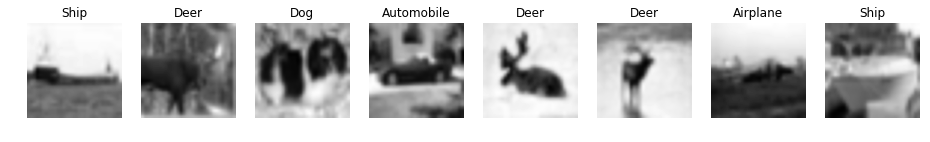

In [4]:
num_plots = 8

fig = plt.figure(figsize=(16, 4))
gs = GridSpec(1, num_plots)
for i in range(num_plots):
    row = np.random.randint(low=0, high=10000)
    ax = plt.subplot(gs[0, i])
    img = data[row, :].reshape((3, 1024)).reshape((3, 32, 32)).T
    ax.imshow(img[:, :, 2].T,
             interpolation='gaussian', origin='upper', cmap=plt.cm.gray)
    ax.set_title('{}'.format(classes[labels[row]]))
    ax.axis('off')
plt.show()

Ran MultinomialNB in 0.17s.

    Overall Accuracy: 0.227
    Mean Precision:   0.245 +/- 0.071
    Mean Recall:      0.227 +/- 0.133
    Mean F1 Score:    0.210 +/- 0.068
    


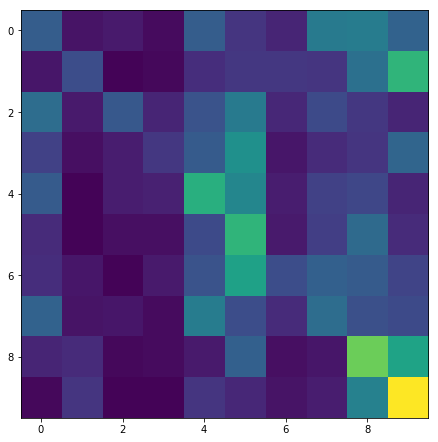

Iteration 1, loss = 9.40318629
Iteration 2, loss = 2.30691974
Iteration 3, loss = 2.30513702
Iteration 4, loss = 2.30400176
Iteration 5, loss = 2.30338179
Iteration 6, loss = 2.30294649
Iteration 7, loss = 2.30317680
Iteration 8, loss = 2.30296509
Iteration 9, loss = 2.30258889
Iteration 10, loss = 2.30250495
Iteration 11, loss = 2.30244877
Iteration 12, loss = 2.30238520
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 9.48035137
Iteration 2, loss = 2.31285440
Iteration 3, loss = 2.30733186
Iteration 4, loss = 2.30579119
Iteration 5, loss = 2.30510155
Iteration 6, loss = 2.30478105
Iteration 7, loss = 2.30470214
Iteration 8, loss = 2.30475429
Iteration 9, loss = 2.30477035
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Ran MLPClassifier in 26.42s.

    Overall Accuracy: 0.097
    Mean Precision:   0.019 +/- 0.039
    Mean Recall:      0.093 +/- 0.187
    Mean F1 Score:    nan +/- 

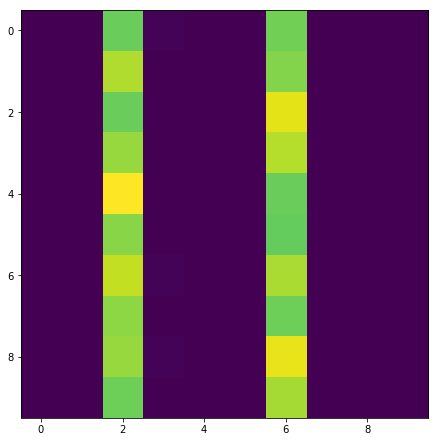

In [18]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA

classifiers = [MultinomialNB, MLPClassifier]

               #[MultinomialNB, SGDClassifier, PassiveAggressiveClassifier, Perceptron, 
               #DecisionTreeClassifier, LogisticRegression, KNeighborsClassifier, RandomForestClassifier][::-1]
kwargs = [None, {'hidden_layer_sizes': (500, ), 
                       'activation': 'relu', 'solver': 'adam', 
                       'alpha': 0.001, 'batch_size': 'auto', 
                       'learning_rate': 'adaptive', 
                       'learning_rate_init': 0.01, 
                       'power_t': 0.5, 'max_iter': 200, 
                       'shuffle': True, 
                       'random_state': None, 
                       'tol': 0.0001, 'verbose': True, 
                       'warm_start': False, 'momentum': 0.9, 
                       'nesterovs_momentum': True, 'early_stopping': False, 
                       'validation_fraction': 0.1, 'beta_1': 0.7, 'beta_2': 0.999, 
                       'epsilon': 1e-08}]
cms = []

#pca = PCA(n_components=500)
training_data = data[:, :1024]

for i, clf in enumerate(classifiers):
    tic = time.time()
    cm = cross_validate_classifier(
                    clf, training_data, labels, training_percentage=0.9, kfold=2,
                    kwargs=kwargs[i])
    toc = time.time() - tic
    cms.append(cm)
    print('Ran {}'.format(clf.__name__) + ' in {:.2f}s.'.format(toc))    
    print(format_classifier_performance(np.mean(cm, axis=0)))
    plot_confusion_matrix([np.mean(cm, axis=0)])
    plt.show()